<a href="https://colab.research.google.com/github/Konstantin5054232/ausbildungsprojekte/blob/main/16_telekomkunden_gehen_weg/telekomkunden_gehen_weg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prognose der Kundenabwanderung für ein Telekommunikationsunternehmen

Der Telekommunikationsbetreiber möchte lernen, wie er die Abwanderung von Kunden vorhersagen kann, indem er ihr Verhalten untersucht. Wenn sich herausstellt, dass der Benutzer beabsichtigt zu gehen, werden ihm Aktionscodes und Sonderkonditionen angeboten. Das Team des Betreibers sammelte persönliche Daten einiger Kunden, Informationen über ihre Tarife und Verträge.

Wir erstellen einen Arbeitsplan.

1. Bibliotheken laden, Daten kennenlernen.
Es ist notwendig zu sehen, wie viele Daten wir haben, welche sich überschneidenden Felder in verschiedenen Dateien sind, um die Datentypen zu untersuchen, um herauszufinden, ob es Lücken in den Daten gibt und wie viele es gibt.

2. Kombinieren von Tabellen, Datenvorverarbeitung.
Es ist unpraktisch, mit mehreren Tabellen zu arbeiten, wir sollten sie zusammenführen. Werden Probleme in den Daten festgestellt (falsche Datentypen, Lücken etc.), müssen diese bearbeitet werden.

3. Arbeiten mit Merkmalen und Zielmerkmalen.
In diesem Abschnitt müssen wir festlegen, welche Funktionen wir zum Trainieren von Modellen verwenden werden. Unter Verwendung der OHE-Technik werden wir kategoriale Merkmale in numerische übersetzen. Befassen wir uns auch mit den Zielmerkmalen: Es gibt ein Abreisedatum des Kunden - der Wert des Zielmerkmals ist 1, nein - 0. Nach dem Codieren der Merkmale werden wir die Daten in einen Trainings- und Validierungstestsatz aufteilen.

4. Modelle bauen.
Wir werden verschiedene Modelle bauen: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier. Wir werden Kreuzvalidierung anwenden, den Schwellenwert ändern und sehen, welche Metriken im Validierungssatz enthalten sein werden, und die optimalen Hyperparameter auswählen.

5. Modelltest.
Wir erhalten die Werte der Metriken auf dem Testset.

## 1. Bibliotheken laden, Daten kennenlernen

In [105]:
# Wir werden die erforderliche Bibliothek laden.
!pip install catboost 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
# Wir importieren die notwendigen Bibliotheken.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

from tqdm import notebook

In [107]:
# Wir laden Tabellen mit Daten.
contract = pd.read_csv('/content/contract.csv')
personal = pd.read_csv('/content/personal.csv')
internet = pd.read_csv('/content/internet.csv')
phone = pd.read_csv('/content/phone.csv')

In [108]:
datas = [contract, personal, internet, phone]
for data in datas:
  display(data.info())
  display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Schlussfolgerungen**

Wir haben Daten von 7043 Kunden erhalten. Einzelne Spalten enthalten Nullwerte. Nachdem wir die empfangenen Daten untersucht haben, sehen wir eine Reihe von Problemen, die beseitigt werden müssen: Die Daten aus der Spalte Gesamtkosten sind vom Objekttyp, die Spaltennamen enthalten Großbuchstaben.

## 2. Kombinieren von Tabellen, Datenvorverarbeitung

In [109]:
# Wir werden die ursprünglichen Tabellen zu einer zusammenführen.
df = (contract
      .merge(personal, on='customerID', how='left')
      .merge(phone, on='customerID', how='left')
      .merge(internet, on='customerID', how='left'))

In [110]:
# Wir konvertieren die Spaltennamen in Kleinbuchstaben.
df.columns = df.columns.str.lower()

In [111]:
# Mal sehen was passiert.
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   int64  
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  multiplelines     6361 non-null   object 
 13  internetservice   5517 non-null   object 
 14  onlinesecurity    5517 non-null   object 
 15  onlinebackup      5517 non-null   object 
 16  deviceprotection  5517 non-null   object 


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


In [112]:
# Wir werden Zeilen finden, in denen Leerzeichen in der Spalte totalcharges vorhanden sind.
df[df['totalcharges'] == ' ']

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,NaN,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


**Schlussfolgerungen**

Wir haben Tabellen zur einfacheren Verwendung kombiniert. Wir haben die Spaltennamen in Kleinbuchstaben geändert. 11 Zeilen der Spalte totalcharges enthalten Leerzeichen anstelle von Werten. Dies sind höchstwahrscheinlich Neukunden, die noch nie bezahlt haben.

## 3. Arbeiten mit Merkmalen und Zielmerkmalen

In [113]:
# Wir berechnen, wie viele Tage der Kunde die Dienste des Betreibers in Anspruch genommen hat.
df['days'] = (pd.to_datetime(df.enddate.replace({'No': '2020-02-01'}))
                  - pd.to_datetime(df.begindate)).dt.days

In [114]:
# Wir markieren, ob der Kunde den Vertrag gekündigt hat oder nicht.
df['on_off'] = df.enddate.apply([lambda x: 0 if x == 'No' else 1])

In [115]:
# Wir markieren, ob der Client mit dem Mehrkanal-Telefonleitungsdienst verbunden ist.
df['phone'] = df.multiplelines.apply([lambda x: 0 if pd.isna(x) or x == 'No' else 1])

In [116]:
# Wir markieren, wenn der Client mit dem Internet verbunden ist.
df['internet'] = df.internetservice.apply([lambda x: 0 if pd.isna(x) else 1])

In [117]:
# Wir werden die Spalte totalcharges für Neukunden mit den Werten aus der Spalte monthlycharges füllen.
df.totalcharges = df.totalcharges.replace(' ', np.nan).astype('float').fillna(df.monthlycharges)

In [118]:
# Mal sehen was passiert.
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   int64  
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  multiplelines     6361 non-null   object 
 13  internetservice   5517 non-null   object 
 14  onlinesecurity    5517 non-null   object 
 15  onlinebackup      5517 non-null   object 
 16  deviceprotection  5517 non-null   object 


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,days,on_off,phone,internet
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,Yes,No,No,No,No,31,0,0,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,Yes,No,Yes,No,No,No,1036,0,0,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,Yes,No,No,No,No,61,1,0,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,Yes,No,Yes,Yes,No,No,1371,0,0,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,61,1,0,1


In [119]:
# Wir werden eine Korrelationsmatrix erstellen.
print(df.corr())

                monthlycharges  totalcharges  seniorcitizen      days  \
monthlycharges        1.000000      0.651182       0.220173  0.247754   
totalcharges          0.651182      1.000000       0.102997  0.826095   
seniorcitizen         0.220173      0.102997       1.000000  0.016514   
days                  0.247754      0.826095       0.016514  1.000000   
on_off                0.193356     -0.198347       0.150889 -0.352673   
phone                 0.490434      0.468516       0.142948  0.331833   
internet              0.763557      0.375229       0.182742  0.038951   

                  on_off     phone  internet  
monthlycharges  0.193356  0.490434  0.763557  
totalcharges   -0.198347  0.468516  0.375229  
seniorcitizen   0.150889  0.142948  0.182742  
days           -0.352673  0.331833  0.038951  
on_off          1.000000  0.040102  0.227890  
phone           0.040102  1.000000  0.210564  
internet        0.227890  0.210564  1.000000  


In [120]:
# Wir entfernen die Spalten, die wir nicht für das Training benötigen.
drop = ['customerid', 'begindate', 'enddate', 'on_off', 'totalcharges']

In [121]:
# Unter Verwendung der OHE-Technik werden kategoriale Merkmale in numerische umgewandelt.
X = pd.get_dummies(df.drop(drop, axis=1), drop_first=True)

In [122]:
# Wir wählen ein Zielmerkmal aus.
y = df['on_off']

In [123]:
# Wir teilen die Trainings- und Testdaten auf.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1234)

**Schlussfolgerungen**

In diesem Abschnitt haben wir neue Spalten erstellt, die für das Lernen benötigt werden, und die nicht benötigten Spalten entfernt. Aus der resultierenden Tabelle wurde das Zielmerkmal hervorgehoben, die Daten wurden in Trainings- und Testproben unterteilt.

Wenn wir eine Korrelationsmatrix erstellen, sehen wir eine signifikante Abhängigkeit von zwei Faktoren: days und total charges. Tatsächlich gilt: Je mehr Tage ein Kunde einen Vertrag hat, desto mehr Geld hat er in der Summe bezahlt. Wir haben das Zeichen total charges entfernt.

## 4. Modelle bauen

In [124]:
# Wir werden eine Liste von Modellen erstellen, die trainiert werden.
models = [
    ('Logistic Regression', LogisticRegression(random_state=1234)),
    ('Random Forest', RandomForestClassifier(random_state=1234)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=1234)),
    ('Stochastic Gradient Descent', SGDClassifier(random_state=1234)),
    ('Multi-layer Perceptron', MLPClassifier(hidden_layer_sizes=(10, 5), random_state=1234)),
]

scoring = ('roc_auc', 'accuracy')
results = pd.DataFrame()

In [125]:
# Wir werden das beste Modell anhand von zwei Metriken auswählen.
for name, model in notebook.tqdm(models):
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    cval = cross_validate(pipe, X_train, y_train, scoring=scoring, n_jobs=-1)
    cval.update(model=name)

    results = pd.concat([results, pd.DataFrame(cval)])

# Выведем результаты
results = results.groupby('model').mean().sort_values(by='test_roc_auc', ascending=False)
results.index.name = 'Model'
results.columns = ['Training (Sek.)', 'Vorhersage (Sek.)',
                   'Durchschnittlicher ROC-AUC', 'Durchschnittliche Accuracy']
display(results)

  0%|          | 0/5 [00:00<?, ?it/s]

,Training (Sek.),Vorhersage (Sek.),Durchschnittlicher ROC-AUC,Durchschnittliche Accuracy
Model,,,,
Gradient Boosting,0.679174,0.013091,0.887164,0.835671
Logistic Regression,0.029502,0.005684,0.848536,0.802727
Random Forest,0.498345,0.087567,0.844401,0.807462
Multi-layer Perceptron,4.828415,0.011528,0.839457,0.798941
Stochastic Gradient Descent,0.065946,0.013189,0.810533,0.772812


**Schlussfolgerungen**

In dieser Phase der Arbeit haben wir ein Modell identifiziert, das die höchsten ROC-AUC und Accuracy Metriken zeigte. Dies ist das Gradient Boosting-Modell. Lassen Sie es uns anhand von Testdaten überprüfen und auch ein fortgeschritteneres Modell dieses Typs CatBoostClassifier ausführen.

## 5. Modelltest

In [126]:
# Überprüfen Sie den Betrieb des GradientBoostingClassifier-Modells auf einem Testset.
model = models[2][1]
model.fit(X_train, y_train)
predict = model.predict(X_test)
predict_proba = model.predict_proba(X_test)[:, 1]

print('ROC-AUC auf Testset: %.3f' % roc_auc_score(y_test, predict_proba))
print('Accuracy auf Testset: %.3f ' % accuracy_score(y_test, predict))

ROC-AUC auf Testset: 0.870
Accuracy auf Testset: 0.840 


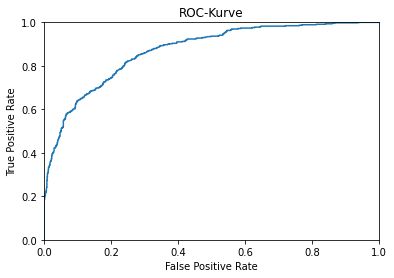

In [127]:
# Wir zeichnen die ROC-Kurve.
fpr, tpr, thresholds = roc_curve(y_test, predict_proba)  

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve')
plt.show() 

In [128]:
# Überprüfen Sie den Betrieb des CatBoostClassifier-Modells auf einem Testset.
catboost = CatBoostClassifier(
    iterations=1100,
    learning_rate=0.1,
    depth=4,
    verbose=200,
    loss_function='CrossEntropy',
    eval_metric='AUC',
    random_state=1234
)
catboost.fit(
    X_train, y_train,
    eval_set=(X_test, y_test)
)

predict = catboost.predict(X_test)
predict_proba = catboost.predict_proba(X_test)[:, 1]

print('ROC-AUC auf Testset: %.3f' % roc_auc_score(y_test, predict_proba))
print('Accuracy auf Testset: %.3f ' % accuracy_score(y_test, predict))

0:	test: 0.7914975	best: 0.7914975 (0)	total: 1.89ms	remaining: 2.07s
200:	test: 0.8917025	best: 0.8917025 (200)	total: 333ms	remaining: 1.49s
400:	test: 0.9089160	best: 0.9089160 (400)	total: 655ms	remaining: 1.14s
600:	test: 0.9150543	best: 0.9150627 (599)	total: 968ms	remaining: 804ms
800:	test: 0.9183400	best: 0.9184423 (795)	total: 1.45s	remaining: 540ms
1000:	test: 0.9192746	best: 0.9192746 (1000)	total: 1.77s	remaining: 175ms
1099:	test: 0.9198620	best: 0.9198620 (1099)	total: 1.93s	remaining: 0us

bestTest = 0.9198619632
bestIteration = 1099

ROC-AUC auf Testset: 0.920
Accuracy auf Testset: 0.878 


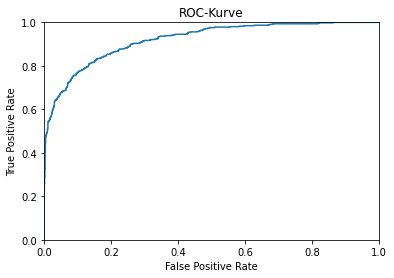

In [130]:
# Wir zeichnen die ROC-Kurve.
fpr, tpr, thresholds = roc_curve(y_test, predict_proba)  

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve')
plt.show() 

**Schlussfolgerungen**

Die Modelle GradientBoostingClassifier und CatBoostClassifier zeigten hohe Werte der ROC-AUC-Metrik auf dem Testset: 0,870 bzw. 0,920. Der Zeitaufwand für das Trainieren von Modellen und das Erstellen von Prognosen erwies sich als unbedeutend. Somit können die Modelle angewendet werden, um den Wechsel von Kunden zu anderen Telekommunikationsbetreibern vorherzusagen.

## Allgemeine Schlussfolgerung

Uns wurden Daten über die Kunden des Telekommunikationsanbieters zur Verfügung gestellt, die einen Vertrag haben und diesen Telekommunikationsanbieter verlassen haben. Unsere Aufgabe bestand darin, ein Modell zur Vorhersage des Verlusts eines Kunden zu erstellen, um zu versuchen, ihn durch die Bereitstellung eines Rabatts oder eines Aktionscodes im Unternehmen zu halten.

Wir haben die Daten vorverarbeitet, in Trainings- und Testsets aufgeteilt. Als nächstes haben wir die Modelle ausgewählt, die auf dem Testmuster die besten Ergebnisse zeigten.

Das Unternehmen kann nun seine Gewinne steigern, indem es die Kundenabwanderung reduziert.